# Conda GreenSurge faugeree

## Imports

In [ ]:
from copy import deepcopy

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ocsmesh
import pyproj
import xarray as xr
from bluemath_tk.topo_bathy.mesh_utils import (
    adcirc2netcdf,
    clip_bati,
    plot_bati,
    plot_bati_interp,
    plot_boundaries,
    plot_mesh_edge,
    plot_mesh_vals,
    read_adcirc_grd,
)
from pyproj import CRS
from shapely.geometry import MultiPolygon, Point, Polygon

## General parameters

### Names and paths

In [2]:
bathymetry_tif_raw_path = "inputs/Tonga_inv_V2.tif"
output_bathy_clip_tif_path = "outputs/Tonga_inv_clip.tif"

site = "Tonga"

### GreenSurge parameters

In [3]:
# Smith & Bank 2 break points
# TODO: Better explain these parameters

Wind_eq = 2
CD_Wl_abc = [0.00063, 0.00723, 0.00723]
Wl_abc = [0, 100, 100]


Wind_speed = 40
Dir_discret = 15
Simul_time = 12
simul_dt_hours = 1
dt_forz = simul_dt_hours

date_ref = [2022, 1, 1, 0, 0, 0]

Eddy = 10
Chezy = 70

In [4]:
"""
GFD info: 
--------- 
Tongatapu domain 
80 cells, 10*11 km resolution 
24 wind directions, 15º resolution 
Unit wind speed: 40m/s 
CD formulation: Wu1982
"""

C1 = 10 * 1000
C2 = 11 * 1000

T = np.sqrt(4 * C1 * C2 / np.sqrt(3))

H_dis_c = 0
H_dis_f = -150

In [5]:
mas = 1  # margen para recortar el raster (coeficiente SU)

H_dis = 0  # Nivel 0 (metros)
Rango_marea = 2.5  # (metros)

# Malla General
Tmin = 200  # Tamaño de celda mínimo (costas y islas) (metros)
Tfuera = 5000  # Tamaño de celda míaximo (contorno de la malla) (metros)
exp_rate = 0.001  # Velocidad de expansión de los triángulos entre Tmin y Tfuera (SU)
C_deb = 30  # Multiplicador de la fila de marea para el detalle a lo largo de la línea de contorno de la forma [Hdis-Rango_marea*C_deb , Hdis+Rango_marea*C_deb] (SU)

In [6]:
point = Point(-175.18531, -21.20102)

coords = [
    [-175.4842625874, -20.6200013383],
    [-174.7444556220, -20.6187918446],
    [-174.7446572043, -21.6460551405],
    [-175.4845145652, -21.6468110740],
    [-175.4842625874, -20.6200013383],
]

In [7]:
UTM_zone = int((point.coords[0][0] + 180) / 6) + 1
UTM_zone

1

## Clip Raster

<Axes: title={'center': 'Raster'}, xlabel='Longitude', ylabel='Latitude'>

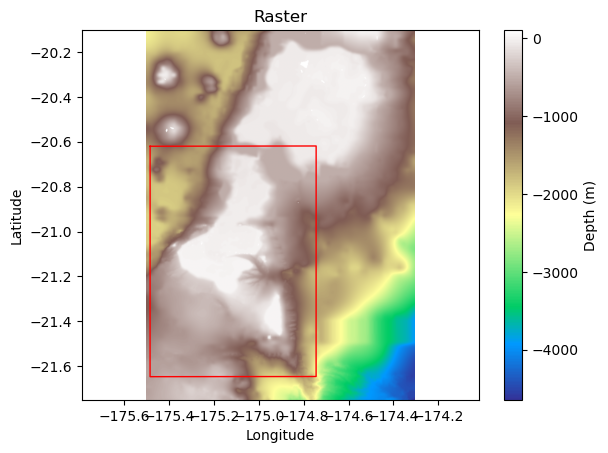

In [8]:
fig, ax = plt.subplots()
rasters_path_I = [bathymetry_tif_raw_path]
domain_crs = CRS.from_user_input("epsg:4326")
domain = Polygon(coords)
plot_bati(rasters_path_I, domain, ax)

<Axes: title={'center': 'Raster'}, xlabel='Longitude', ylabel='Latitude'>

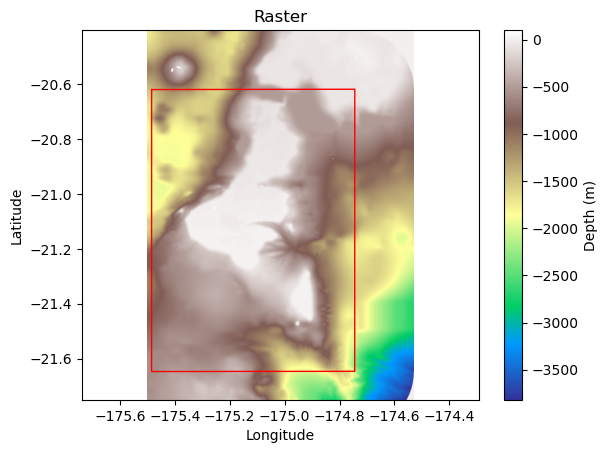

In [9]:
clip_bati(rasters_path_I, output_bathy_clip_tif_path, domain, mas, UTM_zone)
fig, ax = plt.subplots()
rasters_path = [output_bathy_clip_tif_path]
plot_bati(rasters_path, domain, ax)

## Malla de calculo

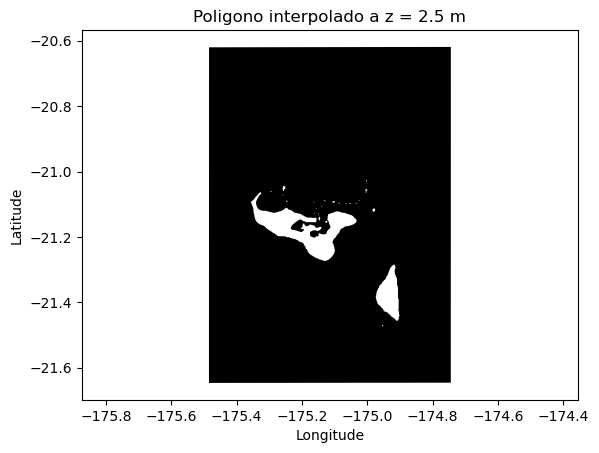

In [10]:
rasters = [ocsmesh.Raster(p) for p in rasters_path]
domain_p = ocsmesh.Geom(rasters, zmax=H_dis + Rango_marea).get_multipolygon()
base_shape = domain_p.intersection(domain)
gpd.GeoSeries(base_shape).plot(color="k")
plt.axis("equal")
plt.title(f"Poligono interpolado a z = {H_dis + Rango_marea} m")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Generacion criterio de diseño

<Axes: title={'center': 'Mesh Design Criteria'}, xlabel='X UTM', ylabel='Y UTM'>

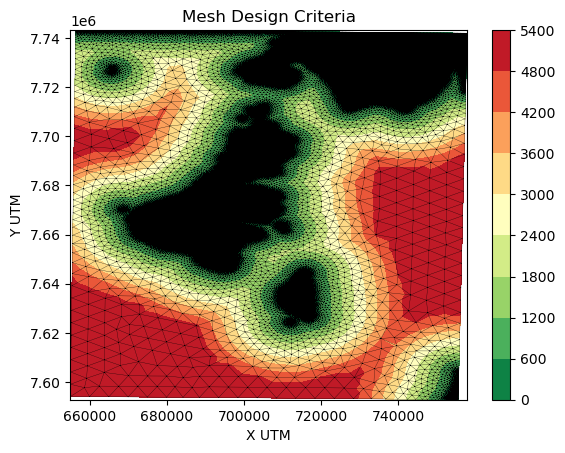

In [11]:
geom = ocsmesh.Geom([], base_shape=base_shape, base_shape_crs=domain_crs)
domain_poly = geom.get_multipolygon()
hfun = ocsmesh.Hfun(deepcopy(rasters), hmin=Tmin, hmax=Tfuera)
hfun.add_topo_bound_constraint(
    value=Tmin,
    upper_bound=H_dis + Rango_marea * C_deb,
    lower_bound=H_dis - Rango_marea * C_deb,
    value_type="max",
    rate=exp_rate,
)
hfun_msht = hfun.msh_t()
ax = plot_mesh_vals(hfun_msht, cmap="RdYlGn_r")
plot_mesh_edge(hfun_msht, lw=0.2, color="k", ax=ax)

### Generacion Malla

In [12]:
driver = ocsmesh.JigsawDriver(geom=geom, hfun=hfun, initial_mesh=False)
mesh = driver.run()
mesh.interpolate(rasters, method="linear")

### Generacion Contornos

No Land boundaries available. Error: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.


(np.float64(656827.4731120444),
 np.float64(735052.0393815765),
 np.float64(7604653.736184375),
 np.float64(7719171.0892651025))

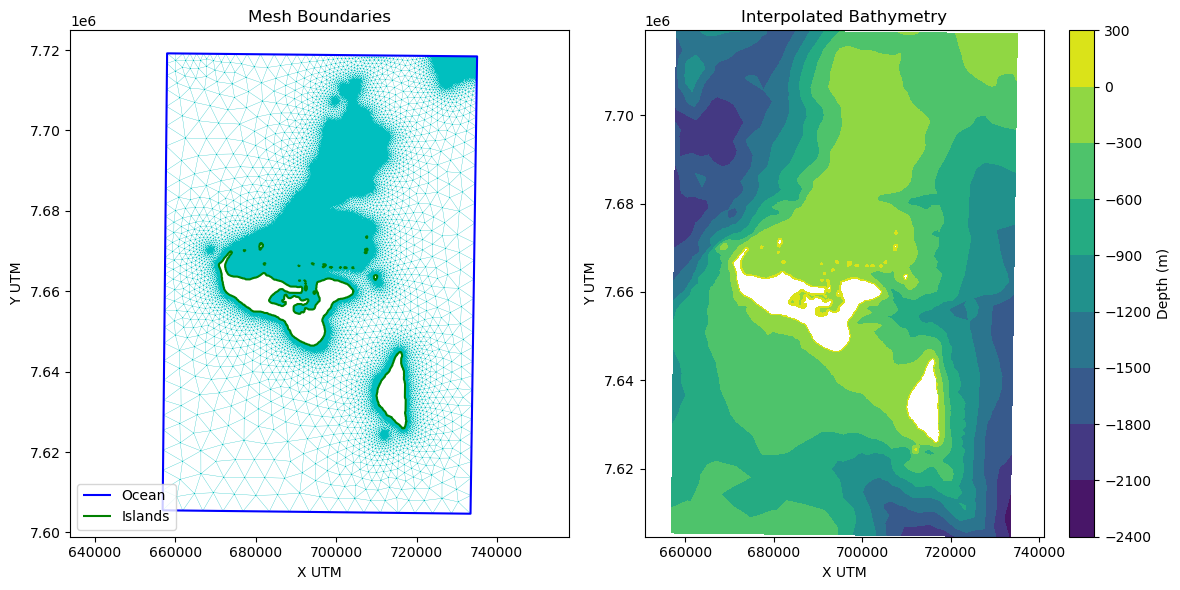

In [13]:
mesh.boundaries.auto_generate(H_dis)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_boundaries(mesh, ax1)
plot_bati_interp(mesh, ax2)
plt.tight_layout()
plt.axis("equal")

### Escritura malla cálculo

In [14]:
path_grd_calc = f"outputs/mesh_{site}_Calc_adcirc.grd"
mesh.write(path_grd_calc, format="grd", overwrite=True)

### Conversion .grd a malla delft3DFM

In [15]:
netcdf_path = f"outputs/mesh_{site}_net.nc"
adcirc2netcdf(path_grd_calc, netcdf_path)

## Malla de forzamiento

Text(130.48626028721367, 0.5, 'Latitude')

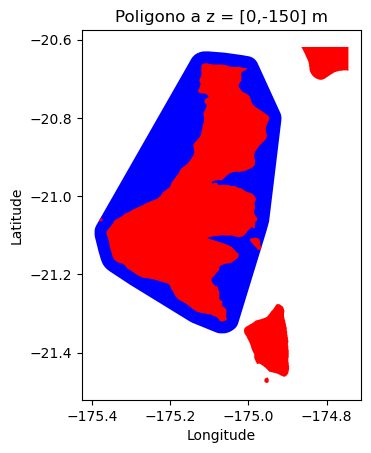

In [16]:
domain_pc = ocsmesh.Geom(rasters, zmax=H_dis_c).get_multipolygon()
base_shape_c = domain_pc.intersection(domain)

base_shape_rev = ocsmesh.Geom(rasters, zmin=H_dis_f).get_multipolygon()
base_shape_rev_I = base_shape_rev.intersection(domain)

for i, polygon in enumerate(base_shape_rev_I.geoms):
    if polygon.contains(point):
        polygon_containing_point = polygon
        break

envelope = polygon_containing_point.convex_hull
envelope_rev = base_shape.difference(envelope)

result = base_shape_c.difference(envelope_rev)

if isinstance(result, MultiPolygon):
    largest_polygon = max(result.geoms, key=lambda p: p.area)
else:
    largest_polygon = result  # result is a single Polygon

# Now perform any further operations with the largest_polygon
cleaned_polygons = Polygon(largest_polygon.exterior)

mas = 0.3
original_polygon = cleaned_polygons.buffer(
    mas * cleaned_polygons.area / cleaned_polygons.length
)

fig, ax = plt.subplots()
gpd.GeoSeries(original_polygon).plot(ax=ax, color="b")
gpd.GeoSeries(base_shape_rev_I).plot(ax=ax, color="r")
plt.title(f"Poligono a z = [{H_dis_c},{H_dis_f}] m")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

<Axes: title={'center': 'Mesh Design Criteria'}, xlabel='X UTM', ylabel='Y UTM'>

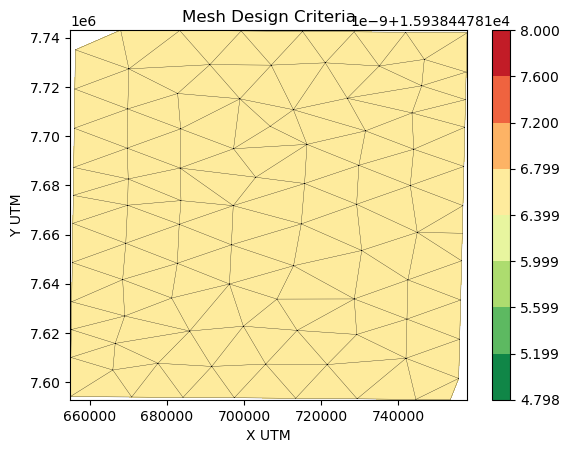

In [17]:
geom_forz = ocsmesh.Geom([], base_shape=original_polygon, base_shape_crs=domain_crs)
domain_poly = geom_forz.get_multipolygon()
hfun_forz = ocsmesh.Hfun(deepcopy(rasters), hmin=T, hmax=T)
hfun_forz.add_topo_bound_constraint(value=T)
hfun_msht = hfun_forz.msh_t()

ax = plot_mesh_vals(hfun_msht, cmap="RdYlGn_r")
plot_mesh_edge(hfun_msht, lw=0.2, color="k", ax=ax)

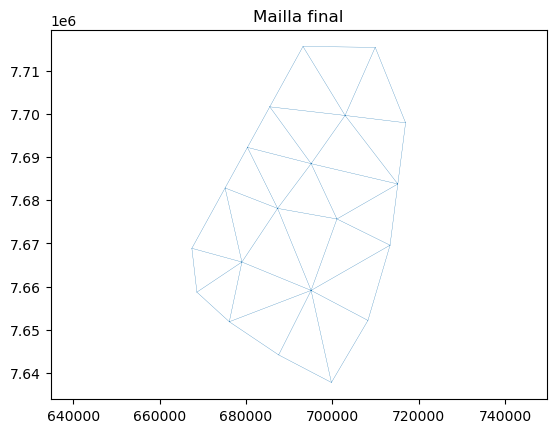

In [18]:
driver_forz = ocsmesh.JigsawDriver(geom=geom_forz, hfun=hfun_forz, initial_mesh=False)

mesh_forz = driver_forz.run()

fig, ax = plt.subplots()
ax.triplot(
    mesh_forz.msh_t.vert2["coord"][:, 0],
    mesh_forz.msh_t.vert2["coord"][:, 1],
    triangles=mesh_forz.msh_t.tria3["index"],
    lw=0.2,
)
ax.axis("equal")
plt.title("Mailla final")
plt.show()

In [19]:
path_grd_forz = f"outputs/mesh_{site}_Viento_adcirc.grd"
mesh_forz.write(path_grd_forz, format="grd", overwrite=True)

## Montaje GreenSurge

In [20]:
Nodes_calc, Elmts_calc, lines_calc = read_adcirc_grd(path_grd_calc)
Nodes_forz, Elmts_forz, lines_forz = read_adcirc_grd(path_grd_forz)

### Presentacion malla

Text(0.5, 1.0, 'Montaje GreenSurge')

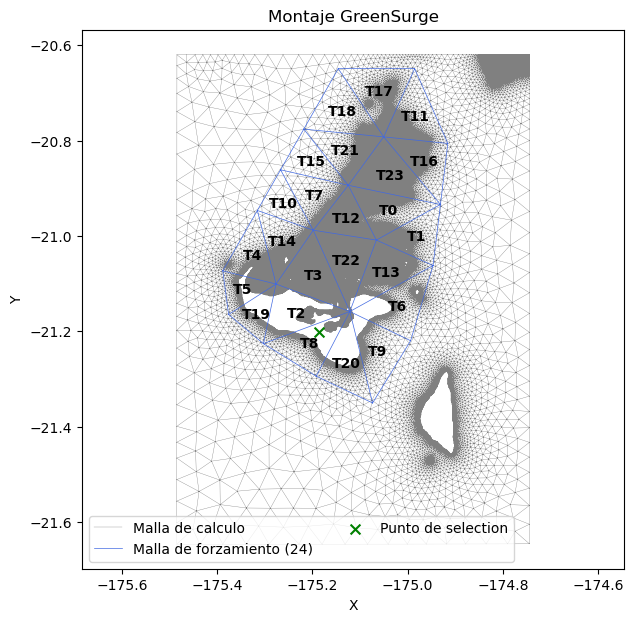

In [21]:
Teselas = len(Elmts_forz)
fig, ax = plt.subplots(figsize=[7, 7])
ax.triplot(
    Nodes_calc[:, 1],
    Nodes_calc[:, 2],
    Elmts_calc[:, 2:5],
    color="grey",
    linestyle="-",
    marker="",
    linewidth=1 / 4,
    label="Malla de calculo",
)
ax.triplot(
    Nodes_forz[:, 1],
    Nodes_forz[:, 2],
    Elmts_forz[:, 2:5],
    color="royalblue",
    linestyle="-",
    marker="",
    linewidth=1 / 2,
    label=f"Malla de forzamiento ({Teselas})",
)
ax.scatter(
    point.coords[0][0],
    point.coords[0][1],
    marker="x",
    color="green",
    s=50,
    label="Punto de selection",
)

for t in range(Teselas):
    node0, node1, node2 = Elmts_forz[t, 2:5]
    x = (
        Nodes_forz[int(node0), 1]
        + Nodes_forz[int(node1), 1]
        + Nodes_forz[int(node2), 1]
    ) / 3
    y = (
        Nodes_forz[int(node0), 2]
        + Nodes_forz[int(node1), 2]
        + Nodes_forz[int(node2), 2]
    ) / 3
    plt.text(x, y, f"T{t}", fontsize=10, ha="center", va="center", fontweight="bold")

ax.set_xlim(Nodes_forz[:, 1].min(), Nodes_forz[:, 1].max())
ax.set_ylim(Nodes_forz[:, 2].min(), Nodes_forz[:, 2].max())
ax.axis("equal")
plt.legend(ncols=2)
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.set_title(f"Montaje GreenSurge")

### Montaje regular grid

In [22]:
transformer_to_utm = pyproj.Transformer.from_proj(
    pyproj.Proj(proj="latlong", datum="WGS84"),
    pyproj.Proj(proj="utm", zone=UTM_zone, ellps="WGS84"),
)

Point_utm = transformer_to_utm.transform(point.coords[0][0], point.coords[0][1])

transformer_to_latlon = pyproj.Transformer.from_proj(
    pyproj.Proj(proj="utm", zone=UTM_zone, ellps="WGS84"),
    pyproj.Proj(proj="latlong", datum="WGS84"),
)

Point_M = transformer_to_latlon.transform(Point_utm[0] + Tmin, Point_utm[1] + Tmin)

dx = abs(point.coords[0][0] - Point_M[0])
dy = abs(point.coords[0][1] - Point_M[1])

In [23]:
lon_grid = np.arange(min(Nodes_forz[:, 1]), max(Nodes_forz[:, 1]) + dx, dx)
lat_grid = np.arange(min(Nodes_forz[:, 2]), max(Nodes_forz[:, 2]) + dy, dy)
M = np.arange(1, lon_grid.size + 1, 1)
N = np.arange(1, lat_grid.size + 1, 1)
NN = [1, 2, 3]
Directions = 360 / Dir_discret
Wdir = np.arange(0, 360, Dir_discret)
Ndir = np.arange(1, Directions + 1, 1)
teselas = np.arange(1, Teselas + 1, 1)
Node = np.arange(1, len(Nodes_forz[:, 1]) + 1, 1)

In [24]:
GFD_lib_info = xr.Dataset(
    coords={
        "CD_Wl_abc": (("CD_Wl_abc"), CD_Wl_abc),
        "Wl_abc": (("Wl_abc"), Wl_abc),
        "M": (("M"), M),
        "N": (("N"), N),
        "NN": (("NN"), NN),
        "teselas": (("teselas"), teselas),
        "Ndir": (("Ndir"), Ndir),
        "Node": (("Node"), Node),
    },
    data_vars={
        "lon_grid": (("M"), lon_grid),
        "lon_grid_360": (("M"), lon_grid + 360),
        "lat_grid": (("N"), lat_grid),
        "lon_node": (("Node"), Nodes_forz[:, 1]),
        "lat_node": (("Node"), Nodes_forz[:, 2]),
        "node_triangle": (("teselas", "NN"), (Elmts_forz[:, 2:5]).astype(int)),
        "Wdir": (("Ndir"), Wdir),
        "NT": (Teselas),
        "simul_hours": (Simul_time),
        "simul_dt_hours": (simul_dt_hours),
        "Wspeed": (Wind_speed),
        "ciudad": (site),
        "Eddy": (Eddy),
        "Chezy": (Chezy),
        "date_ref": (date_ref),
        "CD_ref": ("Wu1982"),
        "dt_forz": (dt_forz),
        "Wind_eq": (Wind_eq),
    },
)

GFD_lib_info.to_netcdf(
    "outputs/Data_1_GFD_lib_info.nc",
    "w",
    "NETCDF3_CLASSIC",
    unlimited_dims="time",
)